In [122]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import math

fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

In [271]:
P = "P"
A = "A"
F = "F"

In [302]:
class Fee():
    def __init__(self, type, value, min_fee=0, zero_on_other_zero=False):
        self.type = type
        self.value = value
        self.min_fee = min_fee
        
        self.zero_on_other_zero = zero_on_other_zero
        
        self.P = P
        self.A = A
        self.F = F
    
    def __add__(self, other):
        return self.value + other
    
    def __radd__(self, other):
        return self.__add__(other)
        
    def __mul__(self, other):
        if (self.type == self.P):
            return max((self.value / 100) * other, self.min_fee)
        elif (self.type == self.A):
            if (self.zero_on_other_zero):
                return (self.value if other > 0 else 0)
            else:
                return self.value
        elif (self.type == self.F):
            return other * self.value
        return self.value
    
    def __rmul__(self, other):
        return self.__mul__(other)

In [303]:
class Broker:
    def __init__(self, conversion_fee, action_fee, period_fee):
        self.conversion_fee = conversion_fee
        self.action_fee = action_fee
        self.period_fee = period_fee
        
    def calculate_period_fee(self, period_invested_money, whole, usdils=0):
        fee_on_investment = 0
        
        if (self.conversion_fee.type == F):
            fee_on_investment += (period_invested_money / usdils) * self.conversion_fee
        else:
            fee_on_investment += period_invested_money * self.conversion_fee
        
        period_invested_money -= fee_on_investment
        
        unrelated_fee = max(whole * self.period_fee, (period_invested_money * self.action_fee) * usdils)
        
        return fee_on_investment, unrelated_fee 

In [304]:
def whole_without_invest(invested_money):
    return np.cumsum(invested_money)

In [305]:
def whole_invest_without_fee(invested_money, period_stock_market_factors):
    output = []
    last_whole = 0
    for (index, factor) in enumerate(period_stock_market_factors):
        output.append(last_whole * factor + invested_money[index])
        last_whole = output[-1]
        
    return np.array(output)

In [317]:
def whole_invest(invested_money, period_stock_market_factors, usdils_history, invest_fund):
    whole_output = []
    cum_fees = []
    
    last_whole = 0
    
    for (index, factor) in enumerate(period_stock_market_factors):
        period_invested_money = invested_money[index]
        # Calculate the whole as the last period yield
        whole = last_whole * factor 
        
        # Subtract all fees
        fee, unrelated_fee = invest_fund.calculate_period_fee(period_invested_money, whole, usdils_history[index])
        
        whole -= fee
        cum_fees.append(unrelated_fee)
        
        whole += period_invested_money
        
        whole_output.append(whole)
        
        last_whole = whole
    
    output = np.array(whole_output) - np.array(np.cumsum(cum_fees))
    
    return output

In [318]:
def cut_by_dates(df, start_date, end_date):
    start = df.index.searchsorted(dt.datetime(*start_date))
    end = df.index.searchsorted(dt.datetime(*end_date))

    return df.iloc[start:end]

def get_monthly(df):
    last_month = df["Date"][0].month
    first_of_month_indices = []

    for date in df["Date"]:
        if (last_month != date.month):
            first_of_month_indices.append(True)
            last_month = date.month
        else:
            first_of_month_indices.append(False)
    
    return df[first_of_month_indices]
            
def get_factors_df(df, price_key="Price", index_key="Date"):
    prices = df[price_key]

    factors = [prices[index + 1] / prices[index] for index in range(len(prices) - 1)]

    return pd.DataFrame({index_key: df[index_key][1:], "Values": factors})

In [319]:
def get_stock_df(file_name, date_format="", price_key="Price"):
    sp500_file = "./Stocks/S&P_500_1927-2020.csv"
    df = pd.read_csv(file_name)
    
    df["Price"] = df[price_key]
    
    df["Date"] = pd.to_datetime(df["Date"], format=date_format)

    df.index = df["Date"] 
    
    return df

def get_monthly_factors(df, start, end):
    range_cut_df = cut_by_dates(df, start, end)
    monthly_df = get_monthly(range_cut_df)
    factors_df = get_factors_df(monthly_df)
    
    return factors_df

In [320]:
sp500_df = get_stock_df("./Stocks/S&P_500_1927-2020.csv", price_key="Close")
spy_df = get_stock_df("./Stocks/SPY_S&P_500_1993-2020.csv", price_key="Close")
usdils_df = get_stock_df("./Stocks/USD-ILS_1990-2020.csv", date_format="%d-%b-%y")

In [337]:
start = (2000, 1, 1)
end = (2014, 3, 1)

sp500_range_cut_df = cut_by_dates(sp500_df, start, end)
sp500_monthly = get_monthly(sp500_range_cut_df)
sp500_factors_df = get_factors_df(sp500_monthly)

usdils_range_cut_df = cut_by_dates(usdils_df, start, end)
usdils_monthly = get_monthly(usdils_range_cut_df)
usdils_factors_df = get_factors_df(usdils_monthly)

spy_df_range_cut_df = cut_by_dates(spy_df, start, end)
spy_df_monthly = get_monthly(spy_df_range_cut_df)
spy_df_factors_df = get_factors_df(spy_df_monthly)

# Assure the indicies of usd are the same as the s&p
# usdils_factors_df["Date"] = sp500_factors_df["Date"]
spy_df_factors_df["Date"] = sp500_factors_df["Date"]

spy_df_factors_df["Values"].describe()

count    168.000000
mean       1.002496
std        0.049427
min        0.836722
25%        0.978560
50%        1.007772
75%        1.030731
max        1.148159
Name: Values, dtype: float64

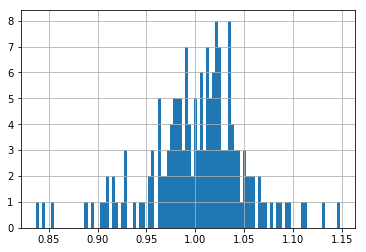

In [338]:
spy_df_factors_df["Values"].hist(bins=100)
plt.show()

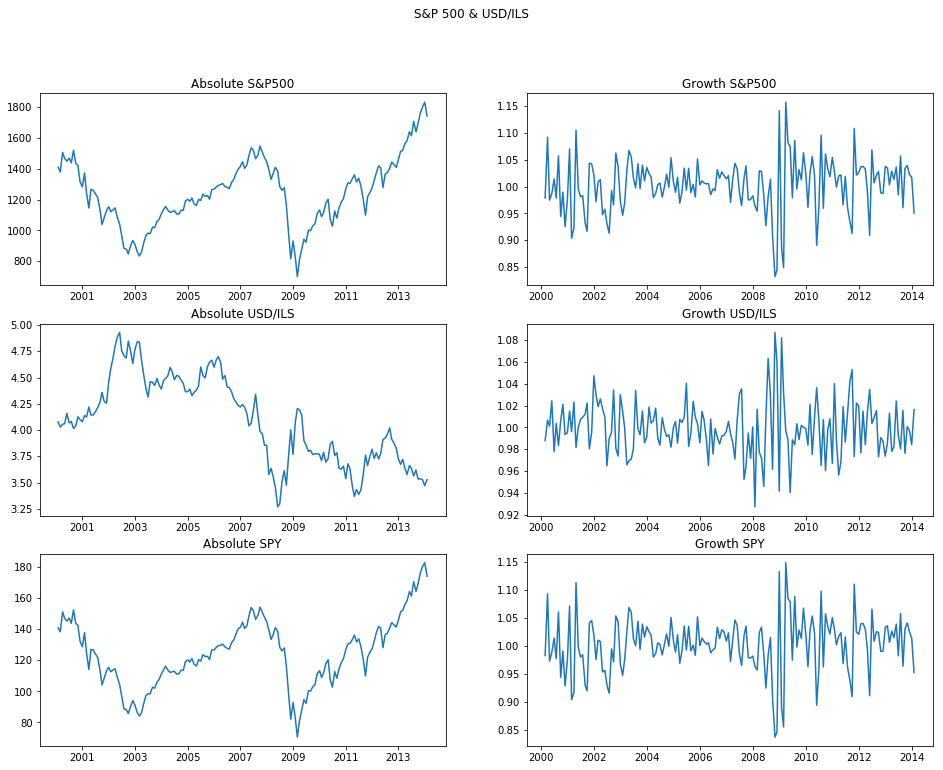

In [339]:
fig, (sp1, sp2, sp3) = plt.subplots(3, 2, figsize=[16,12])

fig.suptitle("S&P 500 & USD/ILS")

sp1[0].plot(sp500_monthly["Date"], sp500_monthly["Price"])
sp1[0].set_title("Absolute S&P500")

sp1[1].plot(sp500_factors_df["Date"], sp500_factors_df["Values"])
sp1[1].set_title("Growth S&P500")

sp2[0].plot(usdils_monthly["Date"], usdils_monthly["Price"])
sp2[0].set_title("Absolute USD/ILS")

sp2[1].plot(usdils_factors_df["Date"], usdils_factors_df["Values"])
sp2[1].set_title("Growth USD/ILS")

sp3[0].plot(spy_df_monthly["Date"], spy_df_monthly["Price"])
sp3[0].set_title("Absolute SPY")

sp3[1].plot(spy_df_factors_df["Date"], spy_df_factors_df["Values"])
sp3[1].set_title("Growth SPY")

plt.show()

In [375]:
start = (1993, 4, 1)
end = (2020, 6, 1)

sp500_factors_df = get_monthly_factors(sp500_df, start, end)
spy_factors_df = get_monthly_factors(spy_df, start, end)
usdils_factors_df = get_monthly_factors(usdils_df, start, end)

usdils_history_df = cut_by_dates(usdils_df, start, end)
usdils_history_df = get_monthly(usdils_history_df)

# Calculate factors for the US stocks
factors = np.array(spy_factors_df["Values"]) * np.array(usdils_factors_df["Values"])

periods = len(factors)

mean_factors = 1.007 * np.ones(periods)

print("periods: {} months, {} years".format(periods, periods / 12), "\n")

psagot = Broker(conversion_fee=Fee(F, 0.01), action_fee=Fee(A, 12, zero_on_other_zero=True), period_fee=Fee(A, 5))

meitav_dash = Broker(conversion_fee=Fee(P, 0.01), action_fee=Fee(A, 20), period_fee=Fee(A, 20)) 
exelence = Broker(Fee(P, 0.01), Fee(A, 20), Fee(A, 15))
interactive = Broker(Fee(P, 0.01), Fee(A, 20), Fee(A, 15))

brokers = [
    meitav_dash,
    psagot,
    exelence,
    interactive
] 
 
invested_money = 10000 * np.ones(periods)

wholes = [whole_invest(invested_money, factors, usdils_history_df["Price"], broker) for broker in brokers]

fig, (sp1) = plt.subplots(1, len(brokers), figsize=[16,12])

for (index, sp) in enumerate(sp1):
    sp.plot(wholes[index])

    
print("meitav_dash: ", wholes[0][-1])
print("psagot: ", wholes[1][-1])
print("diff: ", wholes[0][-1] - wholes[1][-1])
print("psagot: ", wholes[2][-1])
print("interactive: ", wholes[3][-1])
print("diff: ", wholes[0][-1] - wholes[1][-1])

periods: 324 months, 27.0 years 

meitav_dash:  7874907.2407
psagot:  7863253.97772
diff:  11653.2629844
psagot:  7874907.2407
interactive:  7874907.2407
diff:  11653.2629844


In [ ]:
salaries = [500, 2000, 3000, 10000]
cycles = [1,2,3,4]
            
invested_mons = [
    # Create invested money array for each cycle for each salary
    [
        np.array(math.ceil(periods / cycle)*((cycle-1)*[0]+[salary*cycle]))[0: periods] 
        for cycle in cycles
    ] 
                 for salary in salaries
]

predictions = [
    [
        whole_invest(invested_money, mean_factors, usdils_history_df["Price"], psagot) 
        for invested_money in salary
    ]
    for salary in invested_mons
] 

final_amounts = [[prediction[-1] for prediction in salary] for salary in predictions]

In [ ]:
for (salary_index, salary) in enumerate(final_amounts):
    for (cycle_index, final_amount) in enumerate(salary):
        print("salary: {}, cycle: {} -> {}".format(salaries[salary_index], cycles[cycle_index], final_amount))